In [1]:
import time
import os
import random
import numpy as np     
import math

import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


import gym
from gymnasium import spaces

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

from scipy.ndimage import rotate

In [2]:
sys.path.append('../../../../../ocean_intella/ocean_intella/pipelay_profile_optimization/')

In [3]:
import elitism

In [4]:
from scipy.spatial import ConvexHull

In [5]:
import networkx as nx

In [6]:
x0,y0 = 18, 18

# FEM Model

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [8]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [9]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [10]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [11]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [12]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [13]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [14]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show()

# Genetic Modelling

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 2000
HALL_OF_FAME_SIZE = 30

In [18]:
PENALTY_VALUE = 1000.0    

In [19]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [20]:
toolbox = base.Toolbox()

In [21]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [22]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [23]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [24]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 x0*y0+4)

In [25]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [26]:
# convert a binary list to decimal
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [27]:
# fitness calculation
def staticFEM(individual):
    
    args = get_args(*mbb_beam(rd=-1))
    
    x = np.array([t if t==1 else 1e-4 for t in individual[:-4]]) 
    
    try:
        tmp, const = fast_stopt(args, x)
        if const>(55+binatodeci(individual[-4:]))/100:
            return PENALTY_VALUE, 
    except:
        return PENALTY_VALUE, 
    
    
    return tmp,  # return a tuple

In [28]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(x0*y0+4))

In [29]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
    x = np.array(best[:-4]).astype(np.float64).reshape(x0,y0)
    
    args = get_args(*mbb_beam(rd=-1))
    print(fast_stopt(args, x))
    
    draw(x)
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    
    return x

gen	nevals	min    	avg   
0  	300   	95.3478	333763
1  	238   	87.0065	14543.1
2  	244   	81.3308	1138.51
3  	239   	76.685 	140.835
4  	258   	69.1064	113.933
5  	242   	68.3942	100.051
6  	248   	67.6909	100.551
7  	247   	56.9285	111.035
8  	243   	56.9285	105.432
9  	251   	53.1245	141.365
10 	254   	51.0419	138.63 
11 	250   	48.362 	173.428
12 	234   	48.362 	179.593
13 	256   	46.1919	132.162
14 	241   	46.1919	122.914
15 	250   	45.8911	120.849
16 	246   	45.5348	153.621
17 	242   	45.5348	145.696
18 	244   	44.476 	173.229
19 	234   	43.415 	203.86 
20 	247   	43.3051	162.078
21 	249   	42.7744	180.359
22 	248   	42.7744	173.331
23 	250   	41.717 	198.126
24 	238   	41.5653	165.889
25 	247   	41.5653	206.943
26 	253   	41.2154	168.336
27 	232   	40.7608	142.42 
28 	246   	40.5806	189.75 
29 	244   	39.6901	154.362
30 	238   	39.1977	137.954
31 	242   	39.1977	153.456
32 	231   	39.1676	159.42 
33 	242   	38.4558	175.065
34 	247   	37.5905	184.211
35 	236   	37.5905	187.159
36 

303	250   	20.4708	144.618
304	254   	20.4663	203.384
305	233   	20.4437	151.167
306	260   	20.4437	187.14 
307	246   	20.4437	144.653
308	243   	20.4437	144.657
309	241   	20.4437	151.14 
310	251   	20.4437	151.126
311	241   	20.4437	160.921
312	257   	20.4339	164.205
313	247   	20.4339	187.042
314	245   	20.4339	187.035
315	234   	20.4339	154.395
316	237   	20.4339	128.257
317	259   	20.4339	170.684
318	250   	20.4339	196.807
319	252   	20.4339	196.846
320	239   	20.4339	108.684
321	235   	20.4277	164.155
322	240   	20.4277	95.5776
323	257   	20.4277	118.449
324	252   	20.4277	95.6361
325	248   	20.4277	85.7647
326	240   	20.4277	69.4545
327	240   	20.4277	62.9476
328	241   	20.4277	92.3539
329	234   	20.4277	69.4509
330	240   	20.4277	85.7596
331	236   	20.4277	66.1632
332	247   	20.4277	59.7079
333	248   	20.4277	59.6395
334	256   	20.4277	40.0461
335	257   	20.4277	53.1065
336	238   	20.4277	30.2364
337	246   	20.4277	36.7941
338	251   	20.4277	36.804 
339	249   	20.4277	46.6339
3

607	240   	20.2211	39.8408
608	248   	20.2211	43.1062
609	247   	20.2211	59.4496
610	243   	20.2211	30.0314
611	245   	20.2211	46.3591
612	251   	20.2211	39.8393
613	247   	20.2211	56.1591
614	251   	20.2211	52.8991
615	234   	20.2211	59.4373
616	240   	20.2211	65.9638
617	231   	20.2211	33.3317
618	250   	20.2188	46.3571
619	244   	20.2188	39.8357
620	243   	20.2188	39.8375
621	244   	20.2188	33.2988
622	237   	20.2188	46.4263
623	249   	20.2188	39.8466
624	240   	20.2188	36.5623
625	242   	20.2188	72.4893
626	245   	20.2188	56.1572
627	247   	20.2188	56.2494
628	250   	20.2188	49.6905
629	250   	20.2188	56.1587
630	245   	20.2188	43.1084
631	249   	20.2188	52.9059
632	247   	20.2188	36.56  
633	258   	20.2188	39.84  
634	253   	20.2188	43.0979
635	245   	20.2188	62.6954
636	241   	20.2188	49.6249
637	236   	20.2188	33.2994
638	238   	20.2188	43.1023
639	252   	20.2188	39.8409
640	238   	20.2188	43.1323
641	240   	20.2188	52.9075
642	232   	20.2188	36.5681
643	241   	20.2188	33.2976
6

911	251   	20.1981	39.8187
912	244   	20.1981	49.6398
913	242   	20.1981	36.5528
914	243   	20.1981	36.6143
915	244   	20.1981	26.7438
916	243   	20.1981	33.2749
917	238   	20.1981	30.0223
918	238   	20.1981	23.5122
919	244   	20.1981	46.3514
920	239   	20.1981	52.8794
921	238   	20.1981	56.1455
922	252   	20.1981	56.1419
923	239   	20.1981	46.3356
924	244   	20.1981	52.8701
925	244   	20.1981	46.3373
926	248   	20.1981	36.6073
927	248   	20.1981	26.7799
928	251   	20.1981	49.6054
929	253   	20.1981	52.8697
930	248   	20.1981	52.8768
931	254   	20.1981	33.2887
932	242   	20.1981	30.0324
933	236   	20.1981	36.5719
934	231   	20.1981	30.0464
935	244   	20.1981	33.2727
936	240   	20.1981	26.744 
937	247   	20.1981	39.8114
938	250   	20.1981	33.28  
939	237   	20.1981	43.0885
940	246   	20.1981	30.0376
941	252   	20.1981	36.549 
942	249   	20.1981	33.2774
943	237   	20.1981	43.1125
944	253   	20.1981	39.8327
945	251   	20.1981	43.0854
946	245   	20.1981	39.84  
947	245   	20.1981	43.0776
9

1207	254   	20.1612	43.036 
1208	249   	20.1612	56.1073
1209	249   	20.1612	43.0382
1210	250   	20.1612	36.4975
1211	250   	20.1612	46.2981
1212	234   	20.1612	39.8084
1213	239   	20.1612	52.8395
1214	243   	20.1612	46.3043
1215	253   	20.1612	43.0523
1216	250   	20.1612	46.31  
1217	237   	20.1612	43.0521
1218	238   	20.1612	49.6121
1219	245   	20.1612	49.5767
1220	238   	20.1612	43.0415
1221	248   	20.1612	39.7691
1222	242   	20.1612	39.7812
1223	244   	20.1612	36.5011
1224	252   	20.1612	49.5649
1225	248   	20.1612	39.789 
1226	254   	20.1612	26.7146
1227	251   	20.1612	33.2479
1228	254   	20.1612	52.8371
1229	262   	20.1612	49.5804
1230	252   	20.1612	33.2638
1231	255   	20.1612	39.7848
1232	254   	20.1612	39.7687
1233	236   	20.1612	23.4549
1234	241   	20.1612	43.0421
1235	238   	20.1612	36.536 
1236	237   	20.1612	49.574 
1237	239   	20.1612	26.7083
1238	244   	20.1612	33.2485
1239	245   	20.1612	52.8847
1240	239   	20.1612	39.7974
1241	249   	20.1612	46.3306
1242	251   	20.1612	

1500	240   	20.1541	29.9729
1501	241   	20.1541	52.8254
1502	244   	20.1541	39.7644
1503	240   	20.1541	49.5767
1504	252   	20.1541	36.5215
1505	243   	20.1541	43.024 
1506	258   	20.1541	29.9675
1507	248   	20.1541	43.0301
1508	241   	20.1541	33.2324
1509	237   	20.1541	46.2911
1510	257   	20.1541	30.0229
1511	240   	20.1541	29.9648
1512	245   	20.1541	49.5657
1513	241   	20.1541	43.0689
1514	256   	20.1541	43.0323
1515	244   	20.1541	36.5507
1516	242   	20.1541	46.3377
1517	239   	20.1541	39.7981
1518	255   	20.1541	39.8048
1519	238   	20.1541	46.3286
1520	240   	20.1541	33.2494
1521	249   	20.1541	43.038 
1522	258   	20.1541	36.5062
1523	238   	20.1541	33.2596
1524	252   	20.1541	46.2935
1525	244   	20.1541	46.2927
1526	248   	20.1541	43.027 
1527	232   	20.1541	39.7693
1528	239   	20.1541	29.9885
1529	237   	20.1541	46.3038
1530	250   	20.1541	43.0379
1531	243   	20.1541	29.9731
1532	236   	20.1541	36.4998
1533	244   	20.1541	39.7621
1534	249   	20.1541	33.2369
1535	244   	20.1541	

1793	254   	20.1541	36.5361
1794	253   	20.1541	39.7623
1795	243   	20.1541	43.0273
1796	252   	20.1541	39.7757
1797	250   	20.1541	56.0917
1798	239   	20.1541	43.0891
1799	255   	20.1541	52.8262
1800	250   	20.1541	46.2898
1801	236   	20.1541	33.2467
1802	249   	20.1541	39.7628
1803	244   	20.1541	33.2242
1804	238   	20.1541	46.2948
1805	238   	20.1541	46.312 
1806	245   	20.1541	36.5146
1807	251   	20.1541	46.3024
1808	250   	20.1541	39.7954
1809	246   	20.1541	33.2336
1810	243   	20.1541	36.5101
1811	255   	20.1541	56.1022
1812	255   	20.1541	39.7722
1813	232   	20.1541	43.0294
1814	253   	20.1541	52.8284
1815	246   	20.1541	43.0559
1816	251   	20.1541	33.2645
1817	250   	20.1541	46.3544
1818	236   	20.1541	39.7884
1819	237   	20.1541	36.4928
1820	239   	20.1541	46.3018
1821	247   	20.1541	36.5039
1822	247   	20.1541	33.2223
1823	246   	20.1541	36.5411
1824	243   	20.1541	43.0569
1825	252   	20.1541	29.9715
1826	241   	20.1541	46.2947
1827	239   	20.1541	43.0289
1828	248   	20.1541	

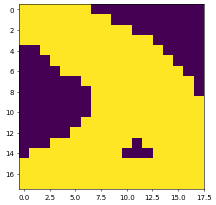

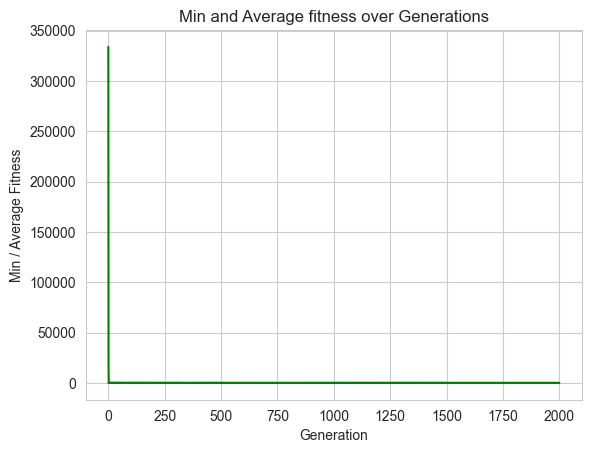

In [30]:
top_=main()

In [31]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                count = 0
                if x[i][j]==1:
                    
                
                    if 0<=i+1<self.n and x[i+1][j]==1:
                        count+=1
                    if 0<=i-1<self.n and x[i-1][j]==1:
                        count+=1 
                    if 0<=j+1<self.m and x[i][j+1]==1:
                        count+=1
                    if 0<=j-1<self.m and x[i][j-1]==1:
                        count+=1   
#                     if i==0 or i== self.n-1 or j==0 or j==self.m-1:
#                         count+=1
                
                
                    if count<4:
                        self.actions_dic[k]=(i,j)
                        k+=1
                        
                elif  x[i][j]==0:
                    x[i][j]+=1e-4
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1e-4
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [32]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self,topology, normalized_image: bool = False):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
#         DIM=self.args.nelx*self.args.nely

        self.topology=topology.copy()
#         mp, const = fast_stopt(self.args, topology)
        self.x = self.topology.copy()
#         mp, const = fast_stopt(self.args, self.x)
#         print(mp)
        self.M=Model(self.x)
#         print(len(self.M.actions_dic))

        N_DISCRETE_ACTIONS=len(self.M.actions_dic)
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=0,
                                            high=255,
                                            shape=(self.args.nely, self.args.nelx, 1),
                                            dtype=np.float64)
        
        
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
#         print(self.x)
        mp, const = fast_stopt(self.args, self.x)
#         print(mp)
        self.M.action_space_(action, self.x)
#         print(self.x)
        tmp, const = fast_stopt(self.args, self.x)
#         print()
#         print(action)
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
                
#         resized_x = resize(self.x, ( self.args.nely, self.args.nelx), anti_aliasing=True)  
#         resized_x = (resized_x * 255).astype(np.uint8).reshape(x0,y0,1)

        return self.x.reshape(x0,y0,1), self.reward, done, False, {}

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = self.topology.copy()

        self.reward=0
        self.needs_reset = False
        self.step_=0
        
#         resized_x = resize(self.x, (self.args.nely, self.args.nelx), anti_aliasing=True)
#         resized_x = (resized_x * 255).astype(np.uint8).reshape(x0,y0,1)

        return self.x.reshape(x0,y0,1), {}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [33]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [34]:
# ts=5e6
ts=5e6

In [35]:
# Create log dir
log_dir = "/tmp/gym_gen_1_2b/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv(topology=top_)
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:30: UserWarning: It seems that your observation  is an image but its `dtype` is (float64) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for 

In [36]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq = 10000, log_dir = log_dir)

In [37]:
start = time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
# model = PPO.load(log_dir + "best_model.zip", env=env).learn(total_timesteps=ts, callback=callback)
end = time.time()   

Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 13.67
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 20000
Best mean reward: 13.67 - Last mean reward per episode: 16.32
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 30000
Best mean reward: 16.32 - Last mean reward per episode: 18.67
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 40000
Best mean reward: 18.67 - Last mean reward per episode: 22.92
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 50000
Best mean reward: 22.92 - Last mean reward per episode: 27.88
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 60000
Best mean reward: 27.88 - Last mean reward per episode: 34.68
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 70000
Best mean reward: 34.68 - Last mean reward per episode: 39.99
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps:

Num timesteps: 740000
Best mean reward: 102.08 - Last mean reward per episode: 84.80
Num timesteps: 750000
Best mean reward: 102.08 - Last mean reward per episode: 83.28
Num timesteps: 760000
Best mean reward: 102.08 - Last mean reward per episode: 81.28
Num timesteps: 770000
Best mean reward: 102.08 - Last mean reward per episode: 77.47
Num timesteps: 780000
Best mean reward: 102.08 - Last mean reward per episode: 75.16
Num timesteps: 790000
Best mean reward: 102.08 - Last mean reward per episode: 74.63
Num timesteps: 800000
Best mean reward: 102.08 - Last mean reward per episode: 76.66
Num timesteps: 810000
Best mean reward: 102.08 - Last mean reward per episode: 80.83
Num timesteps: 820000
Best mean reward: 102.08 - Last mean reward per episode: 84.02
Num timesteps: 830000
Best mean reward: 102.08 - Last mean reward per episode: 85.86
Num timesteps: 840000
Best mean reward: 102.08 - Last mean reward per episode: 86.32
Num timesteps: 850000
Best mean reward: 102.08 - Last mean reward

Num timesteps: 1700000
Best mean reward: 102.08 - Last mean reward per episode: 92.66
Num timesteps: 1710000
Best mean reward: 102.08 - Last mean reward per episode: 93.52
Num timesteps: 1720000
Best mean reward: 102.08 - Last mean reward per episode: 93.69
Num timesteps: 1730000
Best mean reward: 102.08 - Last mean reward per episode: 93.54
Num timesteps: 1740000
Best mean reward: 102.08 - Last mean reward per episode: 94.17
Num timesteps: 1750000
Best mean reward: 102.08 - Last mean reward per episode: 94.25
Num timesteps: 1760000
Best mean reward: 102.08 - Last mean reward per episode: 95.92
Num timesteps: 1770000
Best mean reward: 102.08 - Last mean reward per episode: 97.02
Num timesteps: 1780000
Best mean reward: 102.08 - Last mean reward per episode: 98.73
Num timesteps: 1790000
Best mean reward: 102.08 - Last mean reward per episode: 98.59
Num timesteps: 1800000
Best mean reward: 102.08 - Last mean reward per episode: 98.46
Num timesteps: 1810000
Best mean reward: 102.08 - Last

Num timesteps: 2620000
Best mean reward: 105.25 - Last mean reward per episode: 105.63
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 2630000
Best mean reward: 105.63 - Last mean reward per episode: 105.75
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 2640000
Best mean reward: 105.75 - Last mean reward per episode: 105.75
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 2650000
Best mean reward: 105.75 - Last mean reward per episode: 105.42
Num timesteps: 2660000
Best mean reward: 105.75 - Last mean reward per episode: 105.64
Num timesteps: 2670000
Best mean reward: 105.75 - Last mean reward per episode: 105.59
Num timesteps: 2680000
Best mean reward: 105.75 - Last mean reward per episode: 106.32
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps: 2690000
Best mean reward: 106.32 - Last mean reward per episode: 106.58
Saving new best model to /tmp/gym_gen_1_2b/best_model.zip
Num timesteps:

Num timesteps: 3500000
Best mean reward: 108.09 - Last mean reward per episode: 99.29
Num timesteps: 3510000
Best mean reward: 108.09 - Last mean reward per episode: 99.71
Num timesteps: 3520000
Best mean reward: 108.09 - Last mean reward per episode: 100.33
Num timesteps: 3530000
Best mean reward: 108.09 - Last mean reward per episode: 100.26
Num timesteps: 3540000
Best mean reward: 108.09 - Last mean reward per episode: 99.94
Num timesteps: 3550000
Best mean reward: 108.09 - Last mean reward per episode: 99.78
Num timesteps: 3560000
Best mean reward: 108.09 - Last mean reward per episode: 99.88
Num timesteps: 3570000
Best mean reward: 108.09 - Last mean reward per episode: 99.74
Num timesteps: 3580000
Best mean reward: 108.09 - Last mean reward per episode: 99.47
Num timesteps: 3590000
Best mean reward: 108.09 - Last mean reward per episode: 99.37
Num timesteps: 3600000
Best mean reward: 108.09 - Last mean reward per episode: 99.50
Num timesteps: 3610000
Best mean reward: 108.09 - La

Num timesteps: 4450000
Best mean reward: 108.09 - Last mean reward per episode: 103.77
Num timesteps: 4460000
Best mean reward: 108.09 - Last mean reward per episode: 104.66
Num timesteps: 4470000
Best mean reward: 108.09 - Last mean reward per episode: 105.35
Num timesteps: 4480000
Best mean reward: 108.09 - Last mean reward per episode: 105.65
Num timesteps: 4490000
Best mean reward: 108.09 - Last mean reward per episode: 106.23
Num timesteps: 4500000
Best mean reward: 108.09 - Last mean reward per episode: 106.36
Num timesteps: 4510000
Best mean reward: 108.09 - Last mean reward per episode: 106.17
Num timesteps: 4520000
Best mean reward: 108.09 - Last mean reward per episode: 105.46
Num timesteps: 4530000
Best mean reward: 108.09 - Last mean reward per episode: 104.62
Num timesteps: 4540000
Best mean reward: 108.09 - Last mean reward per episode: 104.14
Num timesteps: 4550000
Best mean reward: 108.09 - Last mean reward per episode: 103.85
Num timesteps: 4560000
Best mean reward: 10

In [38]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 455.458495982488 min


### Inference

In [39]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()
obs=obs[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [40]:
i=0
while i<2000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _ , info = env.step(int(action))
    if dones: 
        break
    i+=1

In [41]:
print(i)

324


In [42]:
fast_stopt(env.args, env.x)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.args to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.args` for environment variables or `env.get_wrapper_attr('args')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for environment variables or `env.get_wrapper_attr('x')` that will search the reminding wrappers.
  logger.warn(


(4696157233.662134, 0.6296364197530865)


Final Cantilever beam design:


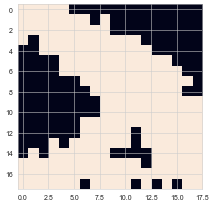

In [43]:
env.render()

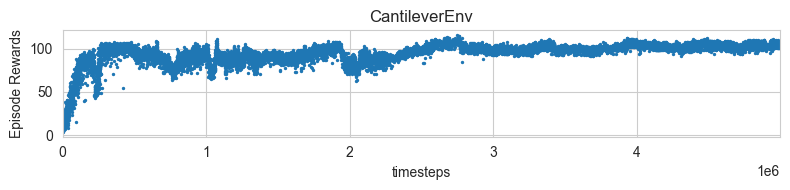

In [44]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [45]:
obs=env.reset()
obs=obs[0]

In [46]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip", env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [47]:
i=0
while i<2000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _ , info = env.step(int(action))
    if dones:
        break
    i+=1

In [48]:
i

324


Final Cantilever beam design:


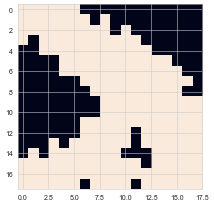

In [49]:
env.render()

In [50]:
# https://stable-baselines3.readthedocs.io/en/master/guide/save_format.html

In [51]:
fast_stopt(env.args, env.x)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.args to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.args` for environment variables or `env.get_wrapper_attr('args')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for environment variables or `env.get_wrapper_attr('x')` that will search the reminding wrappers.
  logger.warn(


(19.875993609193138, 0.6450669753086421)